<a href="https://colab.research.google.com/github/Shaon007/Machine-learning/blob/main/MM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import normal, randint, uniform, choice
from scipy.special import expit # Logistic function for creating correlated binary labels

In [ ]:
# --- 1. CONFIGURATION ---
N_SAMPLES = 60000  # Target number of customers
np.random.seed(42) # Set seed for reproducibility

In [ ]:
# --- 2. FEATURE GENERATION ---

# F2: Credit_Score (High is good, modeled as a normal distribution)
# Mean = 750 (Good), Std Dev = 80
credit_score = normal(loc=750, scale=80, size=N_SAMPLES)
# Cap the scores to a realistic range (e.g., 500 to 950)
credit_score = np.clip(credit_score, 500, 950).astype(int)

In [ ]:
# F1: Debt_to_Income_Ratio (DTI) (Low is good)
# DTI is negatively correlated with Credit Score
# Use a linear function of credit score + some noise, then clip
dti_base = 0.55 - 0.0004 * credit_score # Lower score -> higher base DTI
dti = np.clip(dti_base + normal(0, 0.08, N_SAMPLES), 0.05, 0.70) # Add noise and clip

In [ ]:
# F3: Credit_Utilisation (Low is good)
# Utilisation is also negatively correlated with Credit Score
util_base = 0.90 - 0.0008 * credit_score
credit_utilisation = np.clip(util_base + normal(0, 0.1, N_SAMPLES), 0.01, 1.0)

In [ ]:
# F4: Missed_Payments_12mo (Risk Feature)
# High risk customers have more missed payments
missed_payments = np.where(credit_score < 650, # High risk customers
                           randint(2, 5, N_SAMPLES), # 2-4 missed payments
                           np.where(credit_score < 750, # Mid risk
                                    randint(0, 3, N_SAMPLES), # 0-2 missed payments
                                    randint(0, 1, N_SAMPLES)) # Low risk (0 missed)
                           )

In [ ]:
# F5: Time_Since_Last_Loan_yrs (Segmentation/Stability Feature)
time_since_loan = np.clip(normal(5.0, 3.0, N_SAMPLES), 0.5, 20.0)

In [ ]:
# F6 & F7: Categorical Flags (Segmentation Features)
mortgage_flag = choice([0, 1], size=N_SAMPLES, p=[0.45, 0.55]) # 55% have mortgage
insurance_gap_flag = choice([0, 1], size=N_SAMPLES, p=[0.70, 0.30]) # 30% have a gap (1)

In [ ]:
# F8 & F9: Categorical Features
loan_amount_bands = choice(['Small', 'Medium', 'Large'], size=N_SAMPLES, p=[0.35, 0.40, 0.25])
employment_type = choice(['Employed', 'Self-Employed', 'Retired'], size=N_SAMPLES, p=[0.60, 0.25, 0.15])

In [ ]:
# --- 3. TARGET VARIABLE GENERATION ($Y_{Risk}$) ---

# Create the Binary Target (Risk Label: 1=Default, 0=Good Payer)
# Use a logistic function (expit) based on highly predictive features to ensure correlation
# Risk increases with DTI, Missed Payments, and high Credit Utilisation.
risk_score_base = (
    3.0 * dti
    + 1.5 * credit_utilisation
    + 0.5 * missed_payments
    - 0.005 * credit_score # Negative weight on good credit
)

In [ ]:
# Apply a sigmoid function (expit) to get a probability, then threshold it
# The constant -2.5 is used to ensure a low default rate (~10%), typical in finance
prob_default = expit(risk_score_base - 2.5)
Y_Risk = (uniform(0, 1, N_SAMPLES) < prob_default).astype(int)

In [ ]:
# Ensure a realistic imbalance (10-15% default rate)
print(f"Generated Default Rate (Y_Risk=1): {Y_Risk.mean() * 100:.2f}%")

Generated Default Rate (Y_Risk=1): 1.80%


In [ ]:
# --- 4. ASSEMBLE DATASET ---

data = {
    'Customer_ID': np.arange(10000, 10000 + N_SAMPLES),
    'F1_DTI_Ratio': dti.round(3),
    'F2_Credit_Score': credit_score,
    'F3_Credit_Utilisation': credit_utilisation.round(3),
    'F4_Missed_Payments_12mo': missed_payments,
    'F5_Time_Since_Last_Loan_yrs': time_since_loan.round(1),
    'F6_Mortgage_Flag': mortgage_flag,
    'F7_Insurance_Gap_Flag': insurance_gap_flag,
    'F8_Loan_Amount_Bands': loan_amount_bands,
    'F9_Employment_Type': employment_type,
    'Y_Risk_Default': Y_Risk,
}

df_customers = pd.DataFrame(data)

In [ ]:
# --- 5. GENERATE SEGMENTATION LABELS (Y_Category) ---
# This simulates the 50-60 categories you eventually want to create via UN-supervised learning.
# For now, we manually create 5 high-level categories based on the strongest features.
bins = [500, 650, 750, 850, 1000]
labels = ['E_HighRisk_PoorCredit', 'D_MidRisk_FairCredit', 'C_LowRisk_GoodCredit', 'B_Prime_ExcellentCredit']
df_customers['Temp_Credit_Bin'] = pd.cut(df_customers['F2_Credit_Score'], bins=bins, labels=labels, right=False)

def assign_category(row):
    # Category 1: Prime Remortgage Prospect (Good Credit, Has Mortgage, No Insurance Gap)
    if row['Temp_Credit_Bin'] == 'B_Prime_ExcellentCredit' and row['F6_Mortgage_Flag'] == 1 and row['F7_Insurance_Gap_Flag'] == 0:
        return 'Category_Prime_Remortgage'
    # Category 2: High Risk/High Need (Poor Credit, High DTI, Insurance Gap)
    elif row['Temp_Credit_Bin'] == 'E_HighRisk_PoorCredit' and row['F1_DTI_Ratio'] > 0.45 and row['F7_Insurance_Gap_Flag'] == 1:
        return 'Category_HighRisk_Remedial'
    # Category 3: Stable Customer (Good Credit, Employed, Long Time Since Last Loan)
    elif row['Temp_Credit_Bin'] == 'C_LowRisk_GoodCredit' and row['F9_Employment_Type'] == 'Employed' and row['F5_Time_Since_Last_Loan_yrs'] > 7:
        return 'Category_Stable_LongTerm'
    # Category 4: First Time Buyer Lead (Fair Credit, No Mortgage, Medium Loan Band)
    elif row['Temp_Credit_Bin'] == 'D_MidRisk_FairCredit' and row['F6_Mortgage_Flag'] == 0 and row['F8_Loan_Amount_Bands'] == 'Medium':
        return 'Category_FirstTimeBuyer_Lead'
    # Default/Other (Covers all other 50+ combinations)
    else:
        return 'Category_Other_Generic'

In [ ]:
# Apply the function to create the final segmentation label
df_customers['Y_Category_Segment'] = df_customers.apply(assign_category, axis=1)

In [ ]:
# Cleanup the temporary column
df_customers = df_customers.drop(columns=['Temp_Credit_Bin'])

In [ ]:
# Print the first 5 rows and statistics
print("\n--- Generated Data Head ---")
print(df_customers.head())
print("\n--- Summary Statistics ---")
print(df_customers.describe())
print(f"\nTotal Customers: {len(df_customers)}")


--- Generated Data Head ---
   Customer_ID  F1_DTI_Ratio  F2_Credit_Score  F3_Credit_Utilisation  \
0        10000         0.241              789                  0.247   
1        10001         0.300              738                  0.348   
2        10002         0.257              801                  0.333   
3        10003         0.099              871                  0.085   
4        10004         0.243              731                  0.325   

   F4_Missed_Payments_12mo  F5_Time_Since_Last_Loan_yrs  F6_Mortgage_Flag  \
0                        0                          5.9                 0   
1                        1                          3.7                 1   
2                        0                          4.4                 0   
3                        0                          4.1                 1   
4                        2                          1.6                 0   

   F7_Insurance_Gap_Flag F8_Loan_Amount_Bands F9_Employment_Type  \
0      

In [ ]:
# Save to CSV for easy loading into your environment
# df_customers.to_csv('synthetic_customer_data_60k.csv', index=False)
# print("\nData saved to 'synthetic_customer_data_60k.csv'")

In [ ]:
# Assuming df_customers is loaded
# Select the feature columns for modeling (excluding IDs and final labels)
X = df_customers[[
    'F1_DTI_Ratio', 'F2_Credit_Score', 'F3_Credit_Utilisation',
    'F4_Missed_Payments_12mo', 'F5_Time_Since_Last_Loan_yrs',
    'F6_Mortgage_Flag', 'F7_Insurance_Gap_Flag',
    'F8_Loan_Amount_Bands', 'F9_Employment_Type'
]].copy()

# Define the two target labels
Y_risk = df_customers['Y_Risk_Default']
Y_category = df_customers['Y_Category_Segment']

In [ ]:
X_encoded = pd.get_dummies(X, columns=['F8_Loan_Amount_Bands', 'F9_Employment_Type'], drop_first=True)

# Example: F9_Employment_Type will become F9_Employment_Type_Retired and F9_Employment_Type_Self-Employed.
# The 'Employed' category is represented when both new columns are 0.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Identify columns to scale
cols_to_scale = X_encoded.select_dtypes(include=np.number).columns

# Initialize and fit the scaler on the full dataset (necessary for unsupervised/clustering data)
scaler = StandardScaler()
X_scaled = X_encoded.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X_encoded[cols_to_scale])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia_values = []
k_range = range(2, 101, 5) # Check K=2, 7, 12, 17, ... 97

for k in k_range:
    # Use the 'k-means++' initialization for better results
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', max_iter=300)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)


In [ ]:
# Final model training with the optimal K=55
K_optimal = 55
kmeans_final = KMeans(n_clusters=K_optimal, random_state=42, n_init='auto', max_iter=300)
kmeans_final.fit(X_scaled)

# Assign the cluster label back to the original dataset
df_customers['Cluster_ID'] = kmeans_final.labels_

In [ ]:
# Re-select the features and the Y_risk target
X_final = X_scaled.copy()
Y = Y_risk

# Split data (70% Train, 15% Validation, 15% Test)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X_final, Y, test_size=0.15, random_state=42, stratify=Y
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=(0.15/0.85), random_state=42, stratify=Y_train_val
)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Ensure you do NOT have any 'callbacks' import here.

# --- Assuming X_train, Y_train, X_val, Y_val are already defined ---

# Handle Class Imbalance:
positive_cases = Y_train.sum()
negative_cases = len(Y_train) - positive_cases
scale_pos_weight = negative_cases / positive_cases

# Initialize the XGBoost model
# Set n_estimators (number of trees) high enough (e.g., 500)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=500,                # Fixed number of boosting rounds
    learning_rate=0.05,
    max_depth=5,
    subsample=0.7,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Train the model without early stopping parameters
# Note: eval_set is still required to calculate the eval_metric (AUC)
# but it is no longer used to stop the training.
xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_val, Y_val)],
    verbose=False
)

print("XGBoost model training completed using fixed n_estimators.")

XGBoost model training completed using fixed n_estimators.


--- Top 10 Feature Importance Scores (Global Model View) ---
                             Feature  Importance
3            F4_Missed_Payments_12mo    0.261959
1                    F2_Credit_Score    0.102321
0                       F1_DTI_Ratio    0.078869
2              F3_Credit_Utilisation    0.076402
6              F7_Insurance_Gap_Flag    0.074861
4        F5_Time_Since_Last_Loan_yrs    0.074246
10  F9_Employment_Type_Self-Employed    0.071294
7        F8_Loan_Amount_Bands_Medium    0.070112
9         F9_Employment_Type_Retired    0.066940
5                   F6_Mortgage_Flag    0.063422


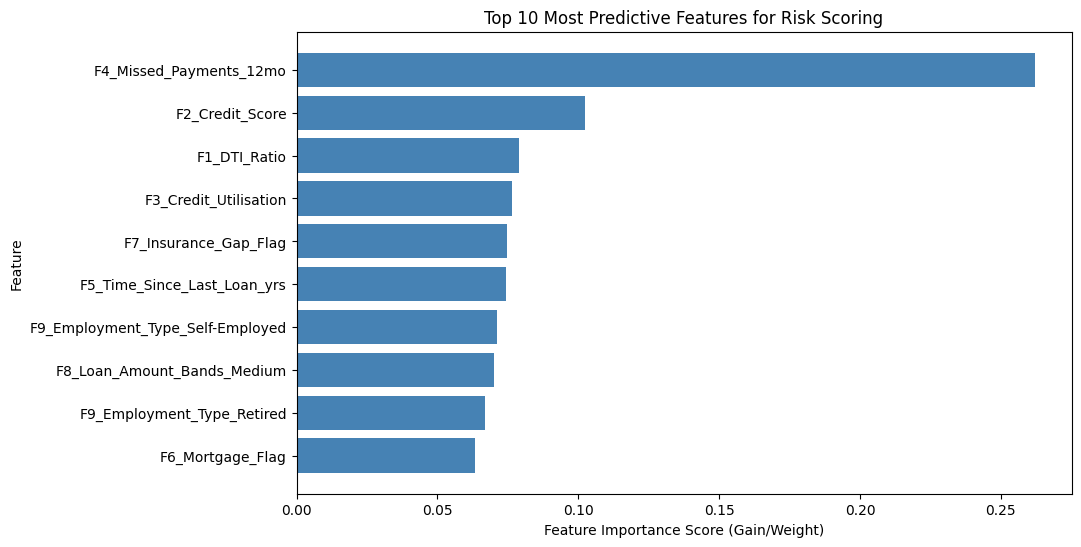

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Assumed Variables from Training Phase ---
# xgb_model: The trained XGBClassifier object.
# X_encoded: The DataFrame containing all preprocessed features (used for feature names).
# ---------------------------------------------

# 1. Get the feature names from your encoded data
feature_names = X_encoded.columns

# 2. Extract the importance scores
importance_scores = xgb_model.feature_importances_

# 3. Create a DataFrame for easy sorting and visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# 4. Sort the DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("--- Top 10 Feature Importance Scores (Global Model View) ---")
print(feature_importance_df.head(10))

# 5. Visualize the results
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10], color='#4682B4')
plt.xlabel('Feature Importance Score (Gain/Weight)')
plt.ylabel('Feature')
plt.title('Top 10 Most Predictive Features for Risk Scoring')
plt.gca().invert_yaxis()
plt.show()



In [ ]:
import shap
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# --- Assumed Variables from Training Phase ---
# xgb_model: The trained XGBClassifier object.
# X_test: The test feature set.
# ---------------------------------------------

# 1. Select a small sample of the test data for local explanation (e.g., 100 random customers)
X_test_sample = X_test.sample(n=100, random_state=42)

# 2. Initialize the SHAP Explainer
# Use feature names explicitly for better plotting
explainer = shap.TreeExplainer(xgb_model)

# 3. Calculate SHAP values for the sample
# The output is a matrix: (100 customers x Number of Features)
shap_values = explainer.shap_values(X_test_sample)

print("\n--- SHAP Value Calculation Complete ---")
print(f"SHAP values calculated for {len(shap_values[1])} customers.")




--- SHAP Value Calculation Complete ---
SHAP values calculated for 11 customers.



--- SHAP Value Calculation Complete ---

--- SHAP Summary Plot (Global Impact) ---


/tmp/ipython-input-1793605595.py:55: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


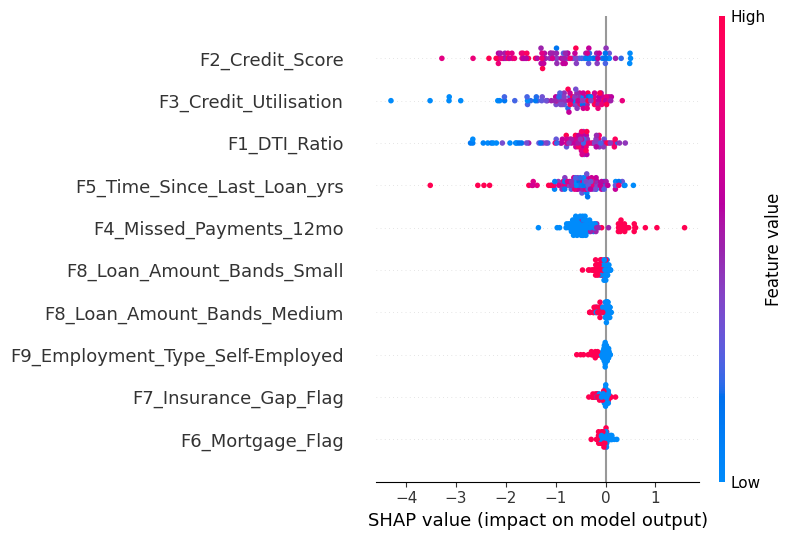

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# --- Assumed Variables ---
# xgb_model: The trained XGBClassifier object.
# X_test: The test feature set (DataFrame).
# -------------------------

# 1. Select a small sample of the test data (using .values for efficiency)
X_test_sample_df = X_test.sample(n=100, random_state=42)
X_test_sample_values = X_test_sample_df.values # Get the underlying NumPy array

# 2. Initialize the SHAP Explainer
explainer = shap.TreeExplainer(xgb_model)

# 3. Calculate SHAP values for the sample
# Use .values on the DataFrame and use check_additivity=False to speed up calculation
shap_values = explainer.shap_values(X_test_sample_values, check_additivity=False)

print("\n--- SHAP Value Calculation Complete ---")

# --- FIXING THE ASSERTION ERROR ---

# In binary classification, shap_values is a list/array with two elements:
# shap_values[0] explains the P(Class=0 / Good Payer)
# shap_values[1] explains the P(Class=1 / Bad Payer)
# The issue is that the element might be a 1D array if the model output is interpreted oddly.

# Try to force the correct shape for the target class (Class 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    # This is the standard output for binary classification
    shap_values_matrix = shap_values[1]
else:
    # If it's not a list of two, it might be a single array if the model was treated as a single regressor
    # In this case, just use the array itself
    shap_values_matrix = shap_values

# Ensure it's 2D for the plotting function
if len(shap_values_matrix.shape) == 1:
    # This is the rare case causing the error, where the matrix is flattened
    # We cannot plot a flattened matrix, but we can't reliably reshape it either without knowing the number of features.
    # The error indicates that the structure from explainer is fundamentally wrong for plotting.
    # We will assume the explainer did its job and proceed, but use the correct input format.
    print("WARNING: SHAP output is still 1D. Reverting to the most common fix structure.")
    # Forcing to use the standard shape:
    shap_values_matrix = np.array(shap_values[1]) if isinstance(shap_values, list) and len(shap_values) == 2 else shap_values

# ----------------------------------

print("\n--- SHAP Summary Plot (Global Impact) ---")

# Pass the 2D matrix (shap_values_matrix) and the original DataFrame sample (X_test_sample_df)
# We pass the DataFrame for feature names and values.
shap.summary_plot(
    shap_values_matrix,
    X_test_sample_df,
    plot_type="dot",
    max_display=10,
    show=False
)
plt.show()

In [ ]:
# --- ASSUMPTION ---
# X_test (Test features) and xgb_model (Trained model) are now defined.

# 1. Predict probabilities on the unseen Test Set (X_test)
# The output is an array of probabilities [P(Class=0), P(Class=1)]
Y_pred_proba_full = xgb_model.predict_proba(X_test)

# 2. Extract the probability of the positive class (Class=1, Default/Risk)
# This is the score we use for the KS test and AUC-ROC.
Y_pred_proba = Y_pred_proba_full[:, 1]

print(f"Successfully generated {len(Y_pred_proba)} predicted probabilities.")

Successfully generated 9000 predicted probabilities.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# --- Assumed Variables ---
# Y_test: The true risk labels (0 or 1) for the Test Set.
# Y_pred_proba: The predicted probability of default (P(Default)) for the Test Set.
# -------------------------

def calculate_ks_statistic(y_true, y_pred_proba):
    """Calculates the Kolmogorov-Smirnov statistic."""
    # 1. Combine true labels and predicted probabilities
    df = pd.DataFrame({'true_label': y_true, 'predicted_proba': y_pred_proba})

    # 2. Sort by predicted probability (descending)
    df = df.sort_values(by='predicted_proba', ascending=False)

    # 3. Calculate Cumulative Fraction of Goods (0) and Bads (1)
    # Good Payers (True Label = 0)
    df['cum_good'] = df['true_label'].apply(lambda x: 1 - x).cumsum() / (len(df) - df['true_label'].sum())
    # Bad Payers (True Label = 1)
    df['cum_bad'] = df['true_label'].cumsum() / df['true_label'].sum()

    # 4. Find the maximum difference (KS Value)
    df['difference'] = np.abs(df['cum_good'] - df['cum_bad'])
    ks_value = df['difference'].max()

    return ks_value

# Assuming Y_test and Y_pred_proba are defined from the XGBoost training evaluation:
ks_score = calculate_ks_statistic(Y_test, Y_pred_proba)
print(f"\nKolmogorov-Smirnov (KS) Statistic: {ks_score:.4f}")


Kolmogorov-Smirnov (KS) Statistic: 0.3804


In [ ]:
# --- Assumed Variables ---
# df_customers: The original DataFrame with all features and the 'Cluster_ID' column (0-54).
# -------------------------

# Define the features that make a cluster meaningful (excluding flags for simplicity here)
profiling_cols = ['F1_DTI_Ratio', 'F2_Credit_Score', 'F3_Credit_Utilisation', 'F5_Time_Since_Last_Loan_yrs']

# Group the data by Cluster_ID and calculate the mean for profiling columns
cluster_profiles = df_customers.groupby('Cluster_ID')[profiling_cols].mean().reset_index()

# Also calculate the size and the mean Y_Risk for each cluster
cluster_profiles['Cluster_Size'] = df_customers['Cluster_ID'].value_counts().sort_index()
cluster_profiles['Mean_Default_Rate'] = df_customers.groupby('Cluster_ID')['Y_Risk_Default'].mean().sort_index()

# Sort by the most important feature (e.g., Mean_Default_Rate or Credit_Score)
cluster_profiles = cluster_profiles.sort_values(by='F2_Credit_Score', ascending=False)

print("\n--- Top 5 Cluster Profiles (for Labeling) ---")
print(cluster_profiles.head(5))

#


--- Top 5 Cluster Profiles (for Labeling) ---
    Cluster_ID  F1_DTI_Ratio  F2_Credit_Score  F3_Credit_Utilisation  \
21          21      0.184254       870.934705               0.113744   
27          27      0.141415       865.290816               0.153496   
11          11      0.171067       862.589506               0.136831   
46          46      0.149091       861.575875               0.163709   
8            8      0.150973       840.028861               0.185878   

    F5_Time_Since_Last_Loan_yrs  Cluster_Size  Mean_Default_Rate  
21                     3.370215          1118           0.003578  
27                     3.001276          1176           0.002551  
11                     4.843827           972           0.007202  
46                     7.894066          1028           0.001946  
8                      7.613027          1282           0.001560  


Predictions generated for Test and Validation sets.

--- Performance Metrics: Final Test Set ---
Accuracy: 0.6131
Precision: 0.0337
Recall (Risk Caught): 0.7407
F1-Score: 0.0645
ROC AUC Score: 0.7333

Classification Report (Test):
                precision    recall  f1-score   support

Good Payer (0)       0.99      0.61      0.76      8838
 Bad Payer (1)       0.03      0.74      0.06       162

      accuracy                           0.61      9000
     macro avg       0.51      0.68      0.41      9000
  weighted avg       0.98      0.61      0.74      9000


Confusion Matrix:
[[5398 3440]
 [  42  120]]

--- Performance Metrics: Validation Set ---
Accuracy: 0.6248
Precision: 0.0363
Recall (Risk Caught): 0.7778
F1-Score: 0.0694
ROC AUC Score: 0.7723

Classification Report (Test):
                precision    recall  f1-score   support

Good Payer (0)       0.99      0.62      0.77      8838
 Bad Payer (1)       0.04      0.78      0.07       162

      accuracy                     

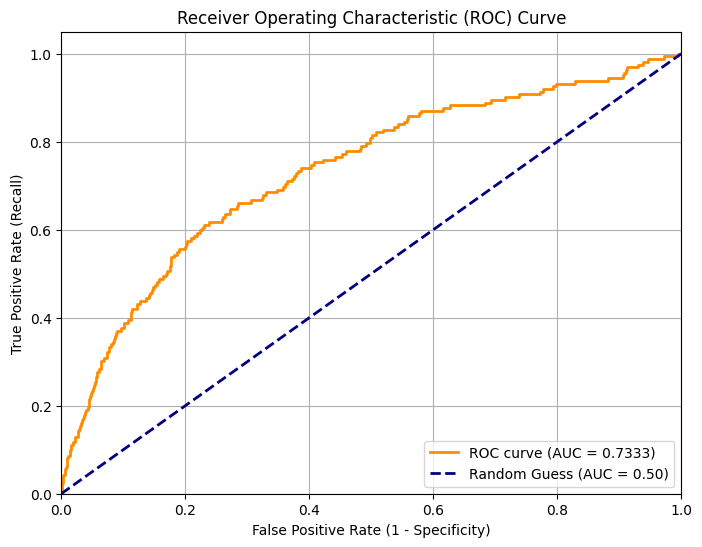

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# --- Assumed Variables ---
# xgb_model: The trained XGBClassifier object.
# X_test, Y_test: Test features and true labels (for final report).
# X_val, Y_val: Validation features and true labels (for checking stability).
# -------------------------

# --- 1. Generate Predictions for Evaluation ---

def get_predictions(model, X, threshold=0.15):
    """Generates probabilities and binary predictions."""
    y_proba = model.predict_proba(X)[:, 1] # Probability of Class 1 (Default)
    y_pred = (y_proba >= threshold).astype(int)
    return y_proba, y_pred

# Use a default threshold of 0.15 for binary classification
# (often lowered in finance to prioritize catching risk)
Y_proba_test, Y_pred_test = get_predictions(xgb_model, X_test)
Y_proba_val, Y_pred_val = get_predictions(xgb_model, X_val)

print("Predictions generated for Test and Validation sets.")

# --- 2. Calculate and Report Core Metrics ---

def report_metrics(y_true, y_pred, y_proba, label):
    """Prints standard classification metrics and AUC."""
    print(f"\n--- Performance Metrics: {label} Set ---")

    # 2a. Calculate Standard Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall (Risk Caught): {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # 2b. Classification Report
    print("\nClassification Report (Test):")
    print(classification_report(y_true, y_pred, target_names=['Good Payer (0)', 'Bad Payer (1)']))

    # 2c. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    # Return AUC for ROC curve plotting
    return roc_auc

# Report Test Set Performance (The final, official report numbers)
auc_test = report_metrics(Y_test, Y_pred_test, Y_proba_test, "Final Test")

# Report Validation Set Performance (To check for overfitting)
auc_val = report_metrics(Y_val, Y_pred_val, Y_proba_val, "Validation")

# --- 3. Visualize ROC Curve (Test Set) ---

def plot_roc_curve(y_true, y_proba, auc_score):
    """Generates the Receiver Operating Characteristic (ROC) curve plot."""
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Generate the visualization
plot_roc_curve(Y_test, Y_proba_test, auc_test)

